In [1]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
filename='preprocessed_data.pkl'

In [3]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [4]:
len(data)

3243

In [5]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [6]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [7]:
X = data['Transcript'].tolist()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [10]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2594
649
2594
649


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [13]:
train_tokenizer = create_tokens(X_train)

In [14]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [15]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [16]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [17]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

847

# CNN-LSTM MODEL - Case 1: Training the model using randomly initialized embedding

In [18]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, LSTM, Bidirectional
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [42]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [44]:
cnn_lstm_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 64, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 46s 20ms/step - loss: 0.6912 - acc: 0.5296 - val_loss: 0.6844 - val_acc: 0.6308
Epoch 2/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.6520 - acc: 0.6585 - val_loss: 0.6112 - val_acc: 0.6885
Epoch 3/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.5241 - acc: 0.7498 - val_loss: 0.5540 - val_acc: 0.7154
Epoch 4/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.3873 - acc: 0.8260 - val_loss: 0.5098 - val_acc: 0.7577
Epoch 5/25
2334/2334 [==============================] - 43s 18ms/step - loss: 0.3142 - acc: 0.8728 - val_loss: 0.5141 - val_acc: 0.7731
Epoch 6/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.2624 - acc: 0.8929 - val_loss: 0.4738 - val_acc: 0.8115
Epoch 7/25
2334/2334 [==============================] - 43s 18ms/step - loss: 0.2265 - acc: 0.9113 - val_loss: 0.4548 - val_acc: 0.8115
E

In [46]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 0s 552us/step


0.8705701079500842

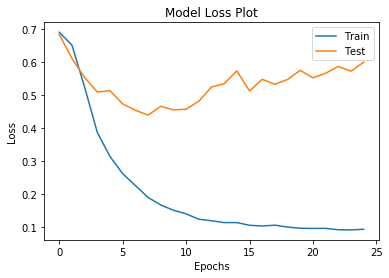

In [48]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [49]:
model.save('cnn_lstm_model.hdf5')   ###save the model

In [43]:
model.load_weights('cnn_lstm_model.hdf5')

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [45]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [46]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[302  40]
 [ 44 263]]
precision is 0.8679867986798679
recall is  0.8566775244299675
F1 score 0.862295081967213
specificity is 0.8830409356725146


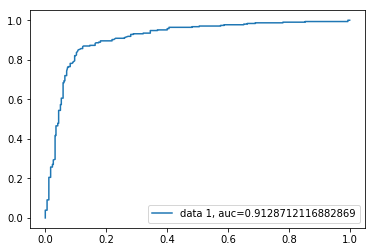

In [25]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# CNN-LSTM model -  Case 2: Model training using pretrained embedding 

In [26]:
embeddings = dict()                                 ##read glove vector file
f = open('../glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [27]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [57]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [58]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 15, batch_size = 64, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/15
2334/2334 [==============================] - 12s 5ms/step - loss: 0.6660 - acc: 0.5797 - val_loss: 0.6399 - val_acc: 0.6308
Epoch 2/15
2334/2334 [==============================] - 5s 2ms/step - loss: 0.5994 - acc: 0.6718 - val_loss: 0.6034 - val_acc: 0.6923
Epoch 3/15
2334/2334 [==============================] - 5s 2ms/step - loss: 0.5020 - acc: 0.7601 - val_loss: 0.5699 - val_acc: 0.7231
Epoch 4/15
2334/2334 [==============================] - 5s 2ms/step - loss: 0.3910 - acc: 0.8286 - val_loss: 0.4944 - val_acc: 0.7500
Epoch 5/15
2334/2334 [==============================] - 5s 2ms/step - loss: 0.2993 - acc: 0.8796 - val_loss: 0.4288 - val_acc: 0.8038
Epoch 6/15
2334/2334 [==============================] - 6s 2ms/step - loss: 0.2661 - acc: 0.8865 - val_loss: 0.4352 - val_acc: 0.8077
Epoch 7/15
2334/2334 [==============================] - 5s 2ms/step - loss: 0.2128 - acc: 0.9117 - val_loss: 0.4240 - val_acc: 0.8154
Epoch 8/15
233

In [59]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 1s 965us/step


0.8443759631118716

# HyperParameter Tuning

In [65]:
def model_cnn_lstm_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=4,units = 128):
    
    model = Sequential()
    e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [66]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] units=10 ........................................................
Epoch 1/10
 - 15s - loss: 0.6639 - acc: 0.6044
Epoch 2/10
 - 5s - loss: 0.5751 - acc: 0.7218
Epoch 3/10
 - 6s - loss: 0.4731 - acc: 0.8091
Epoch 4/10
 - 5s - loss: 0.3797 - acc: 0.8699
Epoch 5/10
 - 5s - loss: 0.2929 - acc: 0.8895
Epoch 6/10
 - 5s - loss: 0.2201 - acc: 0.9294
Epoch 7/10
 - 5s - loss: 0.2590 - acc: 0.9011
Epoch 8/10
 - 5s - loss: 0.1739 - acc: 0.9341
Epoch 9/10
 - 5s - loss: 0.1647 - acc: 0.9312
Epoch 10/10
 - 6s - loss: 0.1274 - acc: 0.9508
[CV] ......................................... units=10, total= 2.2min
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


Epoch 1/10
 - 18s - loss: 0.6571 - acc: 0.6212
Epoch 2/10
 - 6s - loss: 0.5705 - acc: 0.7201
Epoch 3/10
 - 6s - loss: 0.4507 - acc: 0.8068
Epoch 4/10
 - 6s - loss: 0.4253 - acc: 0.8248
Epoch 5/10
 - 6s - loss: 0.2932 - acc: 0.8953
Epoch 6/10
 - 6s - loss: 0.2351 - acc: 0.9132
Epoch 7/10
 - 6s - loss: 0.1873 - acc: 0.9341
Epoch 8/10
 - 6s - loss: 0.1934 - acc: 0.9335
Epoch 9/10
 - 6s - loss: 0.1514 - acc: 0.9387
Epoch 10/10
 - 6s - loss: 0.1806 - acc: 0.9306
[CV] ......................................... units=10, total= 1.7min
[CV] units=10 ........................................................
Epoch 1/10
 - 15s - loss: 0.6498 - acc: 0.6301
Epoch 2/10
 - 6s - loss: 0.5551 - acc: 0.7249
Epoch 3/10
 - 6s - loss: 0.4661 - acc: 0.7948
Epoch 4/10
 - 6s - loss: 0.3681 - acc: 0.8509
Epoch 5/10
 - 6s - loss: 0.2884 - acc: 0.8757
Epoch 6/10
 - 5s - loss: 0.2700 - acc: 0.8832
Epoch 7/10
 - 5s - loss: 0.2010 - acc: 0.9272
Epoch 8/10
 - 5s - loss: 0.1951 - acc: 0.9197
Epoch 9/10
 - 6s - loss: 0.

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 44.1min finished


Epoch 1/10
 - 22s - loss: 0.6555 - acc: 0.6041
Epoch 2/10
 - 11s - loss: 0.5276 - acc: 0.7579
Epoch 3/10
 - 10s - loss: 0.4047 - acc: 0.8454
Epoch 4/10
 - 10s - loss: 0.3156 - acc: 0.8813
Epoch 5/10
 - 10s - loss: 0.2386 - acc: 0.9183
Epoch 6/10
 - 10s - loss: 0.2247 - acc: 0.9198
Epoch 7/10
 - 10s - loss: 0.1788 - acc: 0.9329
Epoch 8/10
 - 11s - loss: 0.1514 - acc: 0.9410
Epoch 9/10
 - 9s - loss: 0.1424 - acc: 0.9418
Epoch 10/10
 - 9s - loss: 0.1409 - acc: 0.9426
Best accuracy:  0.7902852737085582
Best parameters:  {'units': 10}


In [67]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
 - 64s - loss: 0.6648 - acc: 0.6015
Epoch 2/10
 - 45s - loss: 0.5406 - acc: 0.7276
Epoch 3/10
 - 50s - loss: 0.3966 - acc: 0.8132
Epoch 4/10
 - 165s - loss: 0.2874 - acc: 0.8837
Epoch 5/10
 - 32s - loss: 0.2413 - acc: 0.9046
Epoch 6/10
 - 35s - loss: 0.2051 - acc: 0.9121
Epoch 7/10
 - 33s - loss: 0.1810 - acc: 0.9219
Epoch 8/10
 - 33s - loss: 0.1641 - acc: 0.9346
Epoch 9/10
 - 36s - loss: 0.1495 - acc: 0.9422
Epoch 10/10
 - 33s - loss: 0.1441 - acc: 0.9439
[CV] ................................ optimizer=RMSprop, total= 9.6min
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.8min remaining:    0.0s


Epoch 1/10
 - 53s - loss: 0.6630 - acc: 0.5963
Epoch 2/10
 - 41s - loss: 0.5530 - acc: 0.7276
Epoch 3/10
 - 37s - loss: 0.3996 - acc: 0.8219
Epoch 4/10
 - 39s - loss: 0.3019 - acc: 0.8733
Epoch 5/10
 - 36s - loss: 0.2456 - acc: 0.9017
Epoch 6/10
 - 36s - loss: 0.1945 - acc: 0.9150
Epoch 7/10
 - 36s - loss: 0.1622 - acc: 0.9329
Epoch 8/10
 - 36s - loss: 0.1673 - acc: 0.9358
Epoch 9/10
 - 37s - loss: 0.1503 - acc: 0.9375
Epoch 10/10
 - 37s - loss: 0.1449 - acc: 0.9364
[CV] ................................ optimizer=RMSprop, total= 7.0min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
 - 52s - loss: 0.6655 - acc: 0.5803
Epoch 2/10
 - 35s - loss: 0.5503 - acc: 0.7092
Epoch 3/10
 - 42s - loss: 0.4099 - acc: 0.7988
Epoch 4/10
 - 43s - loss: 0.3076 - acc: 0.8601
Epoch 5/10
 - 38s - loss: 0.2432 - acc: 0.8988
Epoch 6/10
 - 39s - loss: 0.2149 - acc: 0.9081
Epoch 7/10
 - 34s - loss: 0.1946 - acc: 0.9191
Epoch 8/10
 - 34s - loss: 0.1621 - acc: 0.9387
Epoch 9/10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 71.8min finished


Epoch 1/10
 - 80s - loss: 0.6493 - acc: 0.6218
Epoch 2/10
 - 65s - loss: 0.4832 - acc: 0.7718
Epoch 3/10
 - 66s - loss: 0.3245 - acc: 0.8624
Epoch 4/10
 - 65s - loss: 0.2324 - acc: 0.9090
Epoch 5/10
 - 65s - loss: 0.1897 - acc: 0.9229
Epoch 6/10
 - 65s - loss: 0.1694 - acc: 0.9345
Epoch 7/10
 - 67s - loss: 0.1540 - acc: 0.9352
Epoch 8/10
 - 65s - loss: 0.1376 - acc: 0.9445
Epoch 9/10
 - 65s - loss: 0.1409 - acc: 0.9418
Epoch 10/10
 - 65s - loss: 0.1194 - acc: 0.9480
Best accuracy:  0.7845026985350809
Best parameters:  {'optimizer': 'Adam'}


In [69]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
 - 77s - loss: 0.6678 - acc: 0.5853
Epoch 2/10
 - 57s - loss: 0.6103 - acc: 0.6686
Epoch 3/10
 - 57s - loss: 0.5044 - acc: 0.7542
Epoch 4/10
 - 58s - loss: 0.3792 - acc: 0.8381
Epoch 5/10
 - 58s - loss: 0.2807 - acc: 0.8855
Epoch 6/10
 - 59s - loss: 0.2280 - acc: 0.9069
Epoch 7/10
 - 58s - loss: 0.2016 - acc: 0.9184
Epoch 8/10
 - 56s - loss: 0.1523 - acc: 0.9422
Epoch 9/10
 - 59s - loss: 0.1353 - acc: 0.9422
Epoch 10/10
 - 57s - loss: 0.1172 - acc: 0.9532
[CV] .................... kernel_size=3, nb_filters=128, total=10.7min
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min remaining:    0.0s


Epoch 1/10
 - 80s - loss: 0.6676 - acc: 0.5922
Epoch 2/10
 - 58s - loss: 0.5862 - acc: 0.6935
Epoch 3/10
 - 58s - loss: 0.4632 - acc: 0.7837
Epoch 4/10
 - 59s - loss: 0.4075 - acc: 0.8167
Epoch 5/10
 - 58s - loss: 0.3123 - acc: 0.8612
Epoch 6/10
 - 58s - loss: 0.3726 - acc: 0.8438
Epoch 7/10
 - 58s - loss: 0.2782 - acc: 0.8803
Epoch 8/10
 - 59s - loss: 0.1996 - acc: 0.9248
Epoch 9/10
 - 58s - loss: 0.1670 - acc: 0.9277
Epoch 10/10
 - 58s - loss: 0.1611 - acc: 0.9329
[CV] .................... kernel_size=3, nb_filters=128, total=10.8min
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
 - 97s - loss: 0.6582 - acc: 0.6012
Epoch 2/10
 - 60s - loss: 0.5975 - acc: 0.6699
Epoch 3/10
 - 60s - loss: 0.5149 - acc: 0.7462
Epoch 4/10
 - 59s - loss: 0.3950 - acc: 0.8197
Epoch 5/10
 - 60s - loss: 0.3105 - acc: 0.8642
Epoch 6/10
 - 64s - loss: 0.2668 - acc: 0.8809
Epoch 7/10
 - 60s - loss: 0.2184 - acc: 0.9046
Epoch 8/10
 - 59s - loss: 0.1664 - acc: 0.9341
Epoch 9/10


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 159.7min finished


Epoch 1/10
 - 132s - loss: 0.6480 - acc: 0.6284
Epoch 2/10
 - 108s - loss: 0.5002 - acc: 0.7475
Epoch 3/10
 - 109s - loss: 0.3545 - acc: 0.8400
Epoch 4/10
 - 108s - loss: 0.2640 - acc: 0.8843
Epoch 5/10
 - 108s - loss: 0.2429 - acc: 0.9002
Epoch 6/10
 - 108s - loss: 0.1839 - acc: 0.9252
Epoch 7/10
 - 108s - loss: 0.1628 - acc: 0.9329
Epoch 8/10
 - 108s - loss: 0.1583 - acc: 0.9329
Epoch 9/10
 - 108s - loss: 0.1514 - acc: 0.9345
Epoch 10/10
 - 108s - loss: 0.1323 - acc: 0.9453
Best accuracy:  0.792212798766384
Best parameters:  {'kernel_size': 5, 'nb_filters': 128}


In [70]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 106s - loss: 0.6588 - acc: 0.5998
Epoch 2/10
 - 81s - loss: 0.5432 - acc: 0.7438
Epoch 3/10
 - 80s - loss: 0.3777 - acc: 0.8352
Epoch 4/10
 - 80s - loss: 0.2674 - acc: 0.8861
Epoch 5/10
 - 81s - loss: 0.2541 - acc: 0.9023
Epoch 6/10
 - 81s - loss: 0.1537 - acc: 0.9375
Epoch 7/10
 - 80s - loss: 0.1399 - acc: 0.9398
Epoch 8/10
 - 80s - loss: 0.1443 - acc: 0.9427
Epoch 9/10
 - 82s - loss: 0.1412 - acc: 0.9393
Epoch 10/10
 - 80s - loss: 0.1230 - acc: 0.9456
[CV] ................................. dropout_rate=0.1, total=14.9min
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.4min remaining:    0.0s


Epoch 1/10
 - 115s - loss: 0.6564 - acc: 0.6032
Epoch 2/10
 - 87s - loss: 0.5249 - acc: 0.7386
Epoch 3/10
 - 87s - loss: 0.3741 - acc: 0.8300
Epoch 4/10
 - 87s - loss: 0.2493 - acc: 0.8959
Epoch 5/10
 - 87s - loss: 0.2024 - acc: 0.9260
Epoch 6/10
 - 87s - loss: 0.1740 - acc: 0.9294
Epoch 7/10
 - 91s - loss: 0.1720 - acc: 0.9341
Epoch 8/10
 - 86s - loss: 0.1281 - acc: 0.9479
Epoch 9/10
 - 88s - loss: 0.1227 - acc: 0.9479
Epoch 10/10
 - 87s - loss: 0.1213 - acc: 0.9462
[CV] ................................. dropout_rate=0.1, total=16.2min
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 202s - loss: 0.6493 - acc: 0.5925
Epoch 2/10
 - 86s - loss: 0.5098 - acc: 0.7566
Epoch 3/10
 - 86s - loss: 0.3739 - acc: 0.8214
Epoch 4/10
 - 87s - loss: 0.2598 - acc: 0.8850
Epoch 5/10
 - 87s - loss: 0.2181 - acc: 0.9017
Epoch 6/10
 - 87s - loss: 0.1926 - acc: 0.9133
Epoch 7/10
 - 87s - loss: 0.1618 - acc: 0.9358
Epoch 8/10
 - 87s - loss: 0.1407 - acc: 0.9376
Epoch 9/1

Epoch 5/10
 - 106s - loss: 0.2228 - acc: 0.9029
Epoch 6/10
 - 106s - loss: 0.1862 - acc: 0.9249
Epoch 7/10
 - 106s - loss: 0.1589 - acc: 0.9358
Epoch 8/10
 - 106s - loss: 0.1466 - acc: 0.9347
Epoch 9/10
 - 106s - loss: 0.1587 - acc: 0.9324
Epoch 10/10
 - 106s - loss: 0.1226 - acc: 0.9497
[CV] ................................. dropout_rate=0.5, total=19.8min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 285.8min finished


Epoch 1/10
 - 196s - loss: 0.6538 - acc: 0.6064
Epoch 2/10
 - 165s - loss: 0.5010 - acc: 0.7548
Epoch 3/10
 - 162s - loss: 0.3413 - acc: 0.8485
Epoch 4/10
 - 162s - loss: 0.2681 - acc: 0.8855
Epoch 5/10
 - 163s - loss: 0.1894 - acc: 0.9202
Epoch 6/10
 - 162s - loss: 0.1718 - acc: 0.9302
Epoch 7/10
 - 162s - loss: 0.1475 - acc: 0.9375
Epoch 8/10
 - 163s - loss: 0.1595 - acc: 0.9356
Epoch 9/10
 - 164s - loss: 0.1267 - acc: 0.9460
Epoch 10/10
 - 169s - loss: 0.1267 - acc: 0.9460
Best accuracy:  0.7918272937548189
Best parameters:  {'dropout_rate': 0.4}


In [72]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 187s - loss: 0.6631 - acc: 0.5853
Epoch 2/10
 - 134s - loss: 0.5531 - acc: 0.7068
Epoch 3/10
 - 134s - loss: 0.4044 - acc: 0.8236
Epoch 4/10
 - 133s - loss: 0.2669 - acc: 0.8924
Epoch 5/10
 - 133s - loss: 0.2037 - acc: 0.9213
Epoch 6/10
 - 134s - loss: 0.1820 - acc: 0.9318
Epoch 7/10
 - 133s - loss: 0.1397 - acc: 0.9451
Epoch 8/10
 - 134s - loss: 0.1285 - acc: 0.9474
Epoch 9/10
 - 134s - loss: 0.1470 - acc: 0.9393
Epoch 10/10
 - 134s - loss: 0.1080 - acc: 0.9566
[CV] .................................... batch_size=32, total=25.5min
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.1min remaining:    0.0s


Epoch 1/10
 - 201s - loss: 0.6616 - acc: 0.5859
Epoch 2/10
 - 128s - loss: 0.5874 - acc: 0.6871
Epoch 3/10
 - 129s - loss: 0.4507 - acc: 0.8034
Epoch 4/10
 - 129s - loss: 0.3245 - acc: 0.8519
Epoch 5/10
 - 129s - loss: 0.2422 - acc: 0.9034
Epoch 6/10
 - 129s - loss: 0.1820 - acc: 0.9312
Epoch 7/10
 - 128s - loss: 0.1491 - acc: 0.9474
Epoch 8/10
 - 131s - loss: 0.1324 - acc: 0.9445
Epoch 9/10
 - 129s - loss: 0.1311 - acc: 0.9422
Epoch 10/10
 - 129s - loss: 0.1253 - acc: 0.9503
[CV] .................................... batch_size=32, total=25.3min
[CV] batch_size=32 ...................................................
Epoch 1/10
 - 198s - loss: 0.6562 - acc: 0.6035
Epoch 2/10
 - 139s - loss: 0.5522 - acc: 0.7197
Epoch 3/10
 - 140s - loss: 0.4022 - acc: 0.8145
Epoch 4/10
 - 139s - loss: 0.3574 - acc: 0.8410
Epoch 5/10
 - 139s - loss: 0.2742 - acc: 0.8867
Epoch 6/10
 - 140s - loss: 0.1953 - acc: 0.9254
Epoch 7/10
 - 140s - loss: 0.1832 - acc: 0.9197
Epoch 8/10
 - 139s - loss: 0.1560 - acc: 

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 291.2min finished


Epoch 1/10
 - 186s - loss: 0.6543 - acc: 0.5975
Epoch 2/10
 - 122s - loss: 0.5583 - acc: 0.7124
Epoch 3/10
 - 121s - loss: 0.4367 - acc: 0.8130
Epoch 4/10
 - 121s - loss: 0.3180 - acc: 0.8705
Epoch 5/10
 - 121s - loss: 0.2327 - acc: 0.9082
Epoch 6/10
 - 121s - loss: 0.2070 - acc: 0.9221
Epoch 7/10
 - 122s - loss: 0.1687 - acc: 0.9318
Epoch 8/10
 - 121s - loss: 0.1513 - acc: 0.9391
Epoch 9/10
 - 121s - loss: 0.1488 - acc: 0.9391
Epoch 10/10
 - 122s - loss: 0.1455 - acc: 0.9383
Best accuracy:  0.7891287577087914
Best parameters:  {'batch_size': 128}


# Model with Optimised Parameters

In [47]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.4))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [22]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 7s 3ms/step - loss: 0.6850 - acc: 0.5480 - val_loss: 0.6775 - val_acc: 0.5923
Epoch 2/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.6504 - acc: 0.6358 - val_loss: 0.6370 - val_acc: 0.6577
Epoch 3/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.6102 - acc: 0.6898 - val_loss: 0.6052 - val_acc: 0.6885
Epoch 4/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.5573 - acc: 0.7369 - val_loss: 0.5801 - val_acc: 0.7192
Epoch 5/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.5008 - acc: 0.7849 - val_loss: 0.5548 - val_acc: 0.7385
Epoch 6/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.4556 - acc: 0.8021 - val_loss: 0.5341 - val_acc: 0.7423
Epoch 7/25
2334/2334 [==============================] - 3s 1ms/step - loss: 0.3826 - acc: 0.8535 - val_loss: 0.4886 - val_acc: 0.7769
Epoch 8/25
2334

In [23]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 3s 4ms/step


0.8721109399993908

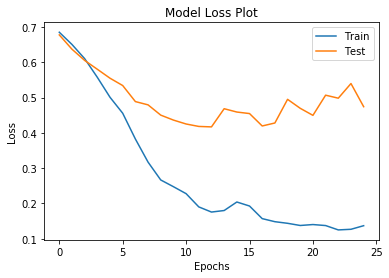

In [25]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_pretrained_history.history['loss'])
plt.plot(cnn_lstm_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [26]:
model.save('cnn_lstm_pretrained_model.hdf5')   ###save the model

In [48]:
model.load_weights('cnn_lstm_pretrained_model.hdf5')

In [49]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [50]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[298  44]
 [ 39 268]]
precision is 0.8589743589743589
recall is  0.8729641693811075
F1 score 0.8659127625201939
specificity is 0.8713450292397661


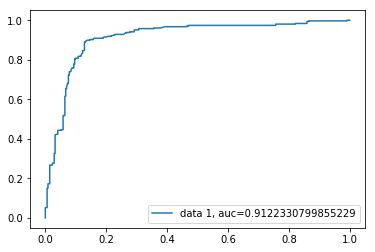

In [32]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()